Pybridizer basic usage example:

This notebook demonstrates how to use Pybridizer to design HCR probes

Import essential functions from the pybridizer probe design module

In [1]:
from pybridizer import read_fasta, create_oligos, blast_oligos, fetch_geneIDs, filter_and_rank, add_hairpin, plot_sequence_alignment

Read a FASTA file containing the transcript sequence for which HCR probes need to be designed. The file should be in a .fasta/.fa/.faa format.

In [ ]:
ID, desc, sequence = read_fasta("Pybridizer\\input\\sox10_zebrafish.fasta")

Transcript ID:  NM_131875.1
Transcript Description:  NM_131875.1 Danio rerio SRY-box transcription factor 10 (sox10), mRNA
Transcript Sequence Length:  3231 nt


Now, the transcript sequence needs to be tiled into oligos (default:25 base length, 2 base gap).

Optional: You can also adjust the length of the oligo, gap between oligos and frame start position (0 i.e. beginning of the transcript by default)

In [4]:
oligos_all = create_oligos(sequence,oligo_length=25,gap_length=2,frame_start_position=0)

Oligos tiled along the transcript sequence:
[Seq('CGTTGTGTGAAGAGCGAGAAAAAAC'), Seq('TGTCGCGCGTCGAGGCTTAAAGAGC'), Seq('TCGCTCGCGCTCTGAATGCCTGCTC'), Seq('GCGCGAGAGTCCGTCGGTTCAGCCC'), Seq('TTTACAGTGCAGCAGGTCGCCCGCC'), Seq('TCCTCAGAATATAGATCTGATGGAA'), Seq('CTGTCAGAAGGAATCCTTCCGCCGT'), Seq('TAACAGTTCTTTTCAAACGACTCGA'), Seq('ATTATTTAAGATCATCCAGTGAAAC'), Seq('TCTTGTAAAATAATTGTGCTTTTGT'), Seq('TTAATTTATACTTCTCAAATGTTTT'), Seq('TTAAATTTTATTTTAAATATAAATG'), Seq('TGACTTCGGTAGGTTTAATTTCCTC'), Seq('TCGGTCCACTAGTTCTGCGGCCACA'), Seq('CCGACATGCTGTGCTCCTCCGCCGA'), Seq('CCGACACCCCGGGACTCATTTCCAC'), Seq('GACCAGGGGACATGGAGTGCCCATC'), Seq('CCGCGCCACCGGGAGCGCCCGACGA'), Seq('GAGACTGCTGACCGGGCAGAGGGGA'), Seq('CTCCATCATCCCCGATCCCGGACAT'), Seq('TCACCGAGACCCCGCCGGAGACACC'), Seq('GGAACCGGTCATCTTCCTCGTCGGA'), Seq('GACTGACCGCCTCGCGGATGCCGAT'), Seq('GCGTCCAGTCGTACCCGTTCAGCAC'), Seq('AGTTCACGCGCACGGGCATGGGCAC'), Seq('TGACGTGCGGTTTGCTCTTGCTGCC'), Seq('ACACCATGAACGCGTTCATCGGCCG'), Seq('CCAGTTTCCTGCGCGCGGCCTGCGC'), Seq

Next, perform a batch BLAST for each of the oligos against your database and save the BLAST results.

!!!Warning!!! : BLAST+ must be installed and a BLAST database should be built using 'makeblastdb' command on the data downloaded from vector base. This is a pre-requisite for the BLAST function to work.

The database name ('dbname') should be your custom BLAST database and the taxonomy ID ('taxid') argument is optional.
Taxonomy ID is essential if you want to run BLAST for a specific species in a database with multiple species.  

In [5]:
blast_result = blast_oligos(oligos_all, dbname='refseq', taxid=7955)

Running batch BLAST on oligos...
BLAST completed successfully


You can view the BLAST results now.

The dataframe lists the query results for each oligo including hits (matches with other transcripts) in the database, length of the matches, match positions and match scores.

In [6]:
blast_result.head()

,qid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,1,NM_131875.1,100.000,25,0,0,1,25,25,1,0.000002,50.1
1,1,NM_001098197.1,100.000,16,0,0,4,19,900,885,0.370000,32.2
2,1,NM_001097586.1,100.000,16,0,0,4,19,790,775,0.370000,32.2
9,1,NM_001076740.2,94.444,18,1,0,6,23,238,221,5.800000,28.2
16,1,NM_001386842.1,94.118,17,1,0,4,20,316,300,23.000000,26.3


The next step is to retreive gene IDs that correspond to transcript IDs. This would be useful if multiple transcript IDs exist for a single gene.

This step is completely optional. 

In [7]:
blast_result_genes = fetch_geneIDs(blast_result,taxid='zebrafish')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
53 input query terms found dup hits:	[('NM_131875.1', 119), ('NM_001193674.1', 2), ('NM_201063.1', 2), ('NM_001003633.1', 2), ('NM_001281


View the blast results with gene IDs appended

In [8]:
blast_result_genes.head()

,qid,geneid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,1,140616,NM_131875.1,100.000,25,0,0,1,25,25,1,0.000002,50.1
1,1,100049175,NM_001098197.1,100.000,16,0,0,4,19,900,885,0.370000,32.2
2,1,794221,NM_001097586.1,100.000,16,0,0,4,19,790,775,0.370000,32.2
9,1,767773,NM_001076740.2,94.444,18,1,0,6,23,238,221,5.800000,28.2
16,1,558610,NM_001386842.1,94.118,17,1,0,4,20,316,300,23.000000,26.3


The oligos need to be filtered based on the GC content and the Melting Temperature. Default range for GC: 37-85 % & Default range for MT: 47-85 C These can also be adjusted in the 'filter and rank' function but is optional.

Based on the BLAST results, neighbouring oligos that hit the same transcript (other than our target gene) should be filtered out. This is to ensure specificity of HCR probes

Lastly, the neighbouring oligo pairs are ranked according to their specificity

In [9]:
probe_datasheet = filter_and_rank(oligos_all,blast_result_genes,Tm_range=[47,85],GC_range=[0.37,0.85])

Filtering oligos based on GC content and Melting Temperature...
Filtering adjacent oligos with same transcript hits...
Generated 32 non-overlapping probe pairs


View the probe datasheet for the optimal set of HCR oligo pairs after filtering

In [10]:
probe_datasheet.head()

,Oligo1_Position,Oligo2_Position,Oligo1_Sequence,Oligo2_Sequence,Score (average hits)
0,61,62,CGGCGTATTCGGCGAATTGTGCGCG,CGTAGTAGGATCCCGAGGCCTGGTG,1.0
1,65,66,GAATGGCGGTGTACAGGGGCCGCTG,GTGACTGCGGCACGGATCCCGGATC,1.5
2,53,54,TAGCGGCCGCTAGCGCGCTGGAGAT,TGGACAGCCATGCGGTGGAGTGGCC,1.5
3,57,58,CCCCAGGGAAGTGTGTTTCACTCTT,TGACGTGTGAACCGCTCGCCGCTGT,2.0
4,75,76,AGGTCTGGACGGTGGTCGTCTGAGG,CTGGTGTCAAATTGGCGTTGAGGGA,2.0


Choose hairpin (B1-B5) for the selected probes to generate final HCR probe pairs

In [11]:
hcr_probes = add_hairpin(probe_datasheet,'B3')

Generating HCR probes...
HCR probes designed


View final HCR probes for the chosen hairpin.
The hcr_probes datasheet has the following columns:

'Oligo1_position' and 'Oligo2_position' columns represent the location of the oligo along the transcript

'Oligo1_Sequence' and 'Oligo2_Sequence' are reverse complement oligos of the two neighbouring 25 base sequence along the transcript

'Score (avg hits)' represents how many other transcripts on average could partially bind to one of the two oligos, but not both. Lower the score, higher the specificity of the probe pair

'HCRprobe1' and 'HCRprobe2' are the final hairpin appended oligos that should be ordered as ssDNA.

In [12]:
hcr_probes.head()

,Oligo1_Position,Oligo2_Position,Oligo1_Sequence,Oligo2_Sequence,Score (average hits),HCRprobe1,HCRprobe2
0,61,62,CGGCGTATTCGGCGAATTGTGCGCG,CGTAGTAGGATCCCGAGGCCTGGTG,1.0,GTCCCTGCCTCTATATCTTTCGGCGTATTCGGCGAATTGTGCGCG,CGTAGTAGGATCCCGAGGCCTGGTGTTCCACTCAACTTTAACCCG
1,65,66,GAATGGCGGTGTACAGGGGCCGCTG,GTGACTGCGGCACGGATCCCGGATC,1.5,GTCCCTGCCTCTATATCTTTGAATGGCGGTGTACAGGGGCCGCTG,GTGACTGCGGCACGGATCCCGGATCTTCCACTCAACTTTAACCCG
2,53,54,TAGCGGCCGCTAGCGCGCTGGAGAT,TGGACAGCCATGCGGTGGAGTGGCC,1.5,GTCCCTGCCTCTATATCTTTTAGCGGCCGCTAGCGCGCTGGAGAT,TGGACAGCCATGCGGTGGAGTGGCCTTCCACTCAACTTTAACCCG
3,57,58,CCCCAGGGAAGTGTGTTTCACTCTT,TGACGTGTGAACCGCTCGCCGCTGT,2.0,GTCCCTGCCTCTATATCTTTCCCCAGGGAAGTGTGTTTCACTCTT,TGACGTGTGAACCGCTCGCCGCTGTTTCCACTCAACTTTAACCCG
4,75,76,AGGTCTGGACGGTGGTCGTCTGAGG,CTGGTGTCAAATTGGCGTTGAGGGA,2.0,GTCCCTGCCTCTATATCTTTAGGTCTGGACGGTGGTCGTCTGAGG,CTGGTGTCAAATTGGCGTTGAGGGATTCCACTCAACTTTAACCCG


Now we can visualize the alignment of the probe pairs to our target transcript sequence and save the output alignment as an image and a FASTA file.

In [ ]:
fig_path = "Pybridizer\\output\\sox10_zebrafish_probe_alignment.png"
align_fasta_path = "Pybridizer\\output\\sox10_zebrafish_probe_alignment.fasta"

Alignment FASTA saved to C:\Users\CTrivedi\Documents\Pybridizer\output\sox10_zebrafish_probe_alignment.fasta


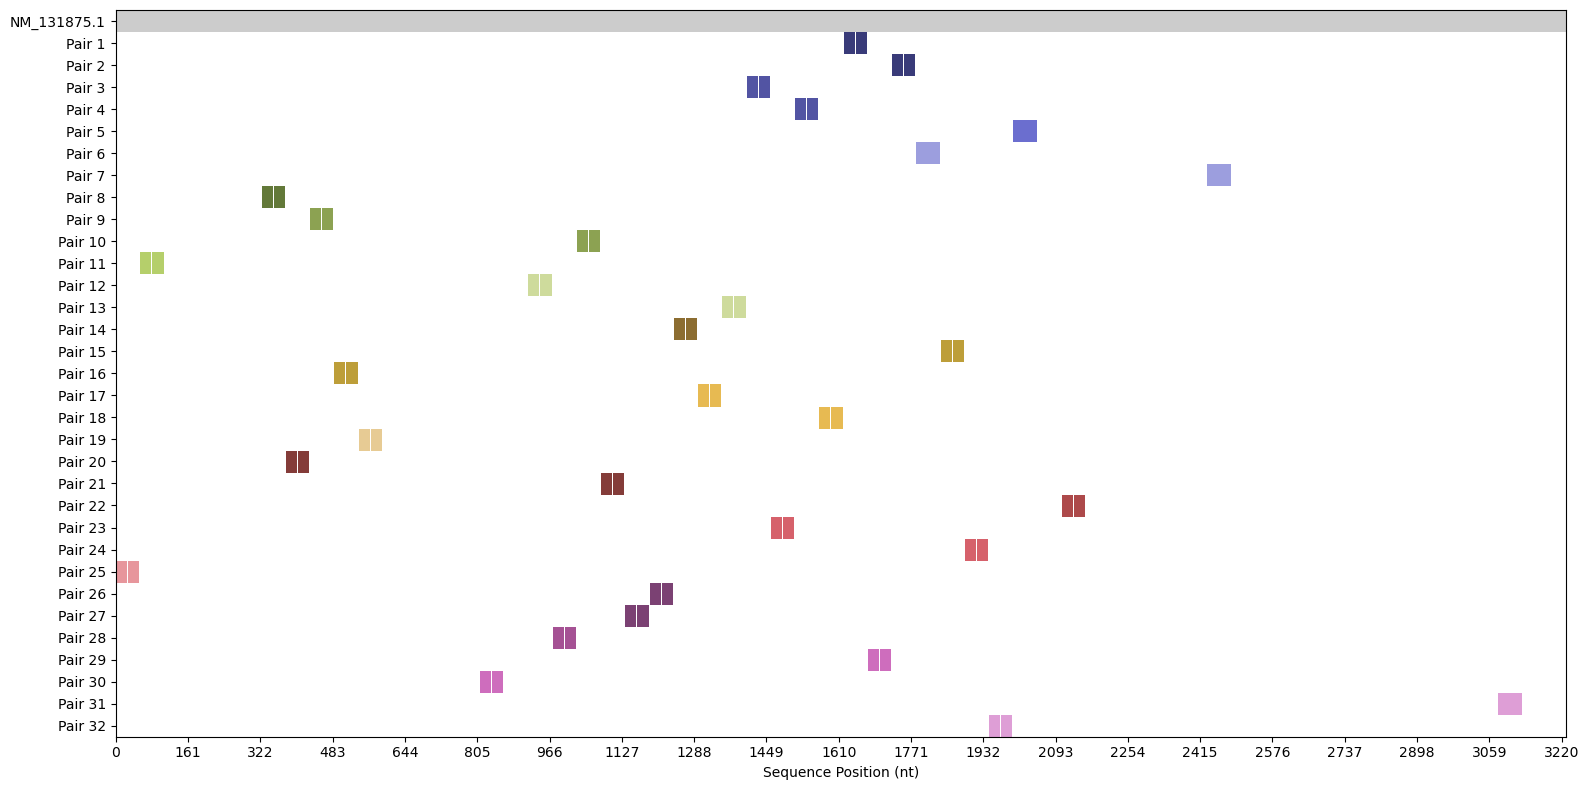

In [14]:
fig,records = plot_sequence_alignment(sequence, ID, probe_datasheet, top_n=None,figsize=(16,8),save_path=fig_path,output_fasta=align_fasta_path)

You can save the designed hcr probes datasheet as an excel file

In [ ]:
hcr_probes.to_excel('Pybridizer\\output\\sox10_hcr_probes_B3.xlsx')